# TP 2

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import random

## Ejercicio 1

In [2]:
arrival_registers = []
with open(r'archivos/datosTP2EJ1.txt', 'r') as f:
    for line in f:
        arrival_registers.append(float(line))

#### Aplico un test de Algomorov-Smirnov para testear la media de los tiempos registrados

In [3]:
arrival_registers.sort()
mean_options = [180, 240]

for opt in mean_options:

    print("H0: mean={}, H1: mean!={}".format(opt, opt))
    s,p = st.kstest(arrival_registers , 'expon', args=(0,opt))

    significance=0.01

    if(p > significance):
        print("Acepto H0 con un pvalue de " + str(p) + " con un nivel de significancia de " + str(significance))
    else:
        print("No acepto H0")

H0: mean=180, H1: mean!=180
Acepto H0 con un pvalue de 0.5735940033913054 con un nivel de significancia de 0.01
H0: mean=240, H1: mean!=240
No acepto H0


Conclusion: Los tiempos registrados siguen una distribucion exponencial con media de 180 segundos

In [4]:
THOUSAND_DAYS = 1000
FULL_DAY = 24*60*60 # in seconds

In [5]:
class Witdrawer(object):
    
    def __init__(self, arrival_time):
        self.arrival_time = arrival_time

    def amount(self):
        return np.random.randint(3, 50)

    def transaction_time(self):
        return np.random.exponential(scale=90)

In [6]:
class Depositor(object):

    def __init__(self, arrival_time):
        self.arrival_time = arrival_time

    def amount(self):
        return np.random.randint(10,110)

    def transaction_time(self):
        return np.random.exponential(scale=500)

In [13]:
class ATM(object):

    MAXBILLS = 2000

    def __init__(self):
        self._currentBills = self.MAXBILLS
        self._occupiedAtmTime = 0
        self.totalTransactions = 0
        self.failedWithdrawers = 0
        self.transactionTimes = []
        self.bills = [self.MAXBILLS]

    def _processTime(self, client):
        waiting_time = 0
        transaction_time = client.transaction_time()
        if (client.arrival_time >= self._occupiedAtmTime):
            self._occupiedAtmTime = client.arrival_time + transaction_time

        elif (self._occupiedAtmTime > client.arrival_time):
            waiting_time = self._occupiedAtmTime - client.arrival_time
            self._occupiedAtmTime += transaction_time

        self.transactionTimes.append( transaction_time + waiting_time )

    def withdraw(self, withdrawerObj, trackBills = False):
        amount = withdrawerObj.amount()
        if (self._currentBills - amount) < 0:
            self.failedWithdrawers += 1  #Solo interesan failed withdrawers y no failed depositers?
        else:
            self._currentBills -= amount

        self.totalTransactions += 1
        self._processTime(withdrawerObj)
        if trackBills:
            self.bills.append(self._currentBills)

    def deposit(self, depositorObj, trackBills = False):
        amount = depositorObj.amount()
        if (self._currentBills + amount) > self.MAXBILLS:
            pass 
        else:
            self._currentBills += amount

        self.totalTransactions += 1
        self._processTime(depositorObj)
        if trackBills:
            self.bills.append(self._currentBills)

    def reset(self):
        self._currentBills = self.MAXBILLS
        self._occupiedAtmTime = 0

In [8]:
types = ['withdrawer','withdrawer', 'withdrawer', 'depositor']

atm = ATM()
arrival_time = 0
random_day_to_track = np.random.randint(0,1000)
for i in range(THOUSAND_DAYS):
    arrival_time = 0
    trackBills = True if i == random_day_to_track else False
    while arrival_time < FULL_DAY:
        arrival_time += np.random.exponential(scale=180)
        clientType = random.choice(types)
        if clientType == 'withdrawer':
            withdrawer = Witdrawer(arrival_time)
            atm.withdraw(withdrawer, trackBills)

        else:
            depositor = Depositor(arrival_time)
            atm.deposit(depositor, trackBills)
    atm.reset()

In [9]:
num_transactions = len(atm.bills)
x = np.arange(0, num_transactions)

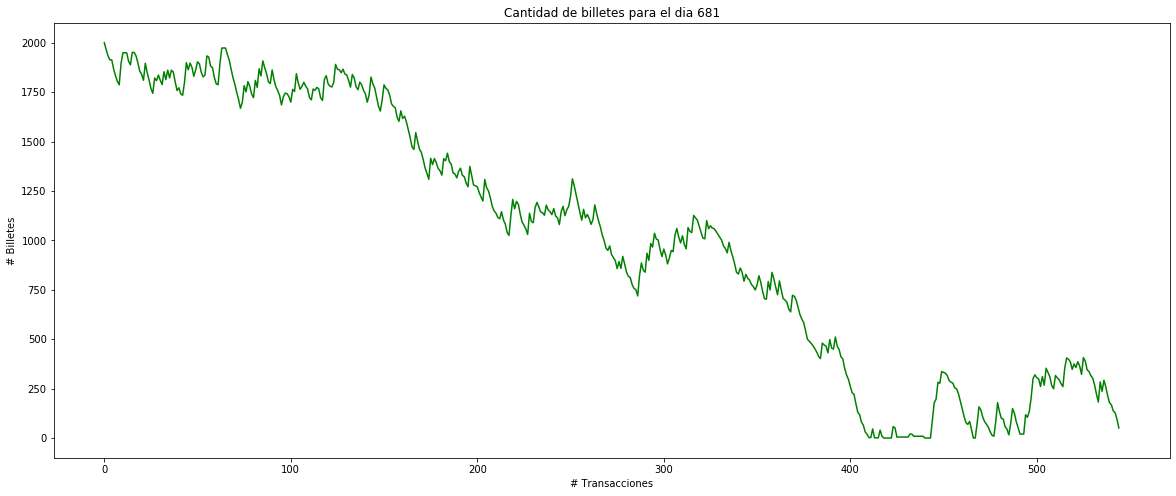

In [10]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_ylim((-100,2100)); ax.set_ylabel("# Billetes"); ax.set_xlabel("# Transacciones")
ax.set_title("Cantidad de billetes para el dia {}".format(random_day_to_track))
ax.plot(x, atm.bills, 'g')

In [11]:
print("Tiempo medio que los clientes demoraron en el sistema: {:.2f} segundos".format(np.mean(atm.transactionTimes)))

Tiempo medio que los clientes demoraron en el sistema: 5893.63 segundos


Tiempo medio de todos los clientes (tiempo de espera + tiempo usando el cajero)

In [12]:
failedTransactions = (atm.failedWithdrawers/atm.totalTransactions)*100
print("Porcentaje de clientes que se fueron sin retirar dinero: % {:.2f} ".format(failedTransactions))

Porcentaje de clientes que se fueron sin retirar dinero: % 4.65 


Como el porcentaje de clientes que se fueron sin retirar dinero es mucho menor a % 20 (porcentaje con el cajero actual) recomiendo a la empresa cambiar de cajero

## Ejercicio 2
- Determine la matriz de transición de estados explicando cómo se obtiene la misma.
- Utilizando  Matlab,  Octave  o  Python  simule  la  evolución del  sistema  a  lo  largo  de  1.000  segundos suponiendo que el servidor comienza sin estar procesando solicitudes.
- Realice un gráfico mostrando la cantidad de solicitudes en el servidor en cada instante de tiempo.
- Realice un histograma mostrando cuantas veces el sistema estuvo en cada estado.
- Determine el % de tiempo que el servidor se encuentra sin procesar solicitudes.

$P = \begin{pmatrix}1-q & q \\ p & 1-p \end{pmatrix}$

$p=\frac{1}{40}, q=\frac{1}{30}$

$A$: llega una solicitud nueva al servidor

$B$: una solicitud es procesada y deja el sistema

![Markov](archivos/markov.png)

En un momento determinado, el servidor se encuentra recibiendo una solicitud nueva ($A$) o procesando una solictud ($B$). La probabilidad $p$ de que "llegue una nueva solicitud" es la probabilidad de transicionar de $B$ a $A$ y la probabilidad $q$ de que "una solicitud termine de ser procesada y deje el sistema" es la probabilidad de transicionar de $A$ a $B$. Las probabilidades de transicionar de $A$ a $A$ y $B$ a $B$ son $1-q$ y $1-p$ respectivamente.

In [24]:
estado_anterior = 'A'

# Se comienza sin solicitudes a procesar
solicitudes = []
solicitudes_en_tiempo = []

# Cantidad de eventos A
cant_sin_procesar = 0

transiciones = {
  'A -> A': 0,
  'A -> B': 0,
  'B -> B': 0,
  'B -> A': 0
};

# Realizar 10000 eventos (un evento cada 10ms por 1000seg)
for i in range(1000*10):
    u = random.random()
    if estado_anterior == 'A':
        cant_sin_procesar += 1
        if u <= 29/30:
            solicitudes.append(i)
            transiciones['A -> A'] += 1;
        else:
            try:solicitudes.pop(0)
            except:pass
            estado_anterior = 'B'
            transiciones['A -> B'] += 1;
    else:
        if u <= 39/40:
            try:solicitudes.pop(0)
            except:pass
            transiciones['B -> B'] += 1;
        else:
            solicitudes.append(i)
            estado_anterior = 'A'
            transiciones['B -> A'] += 1;
    solicitudes_en_tiempo.append(len(solicitudes))


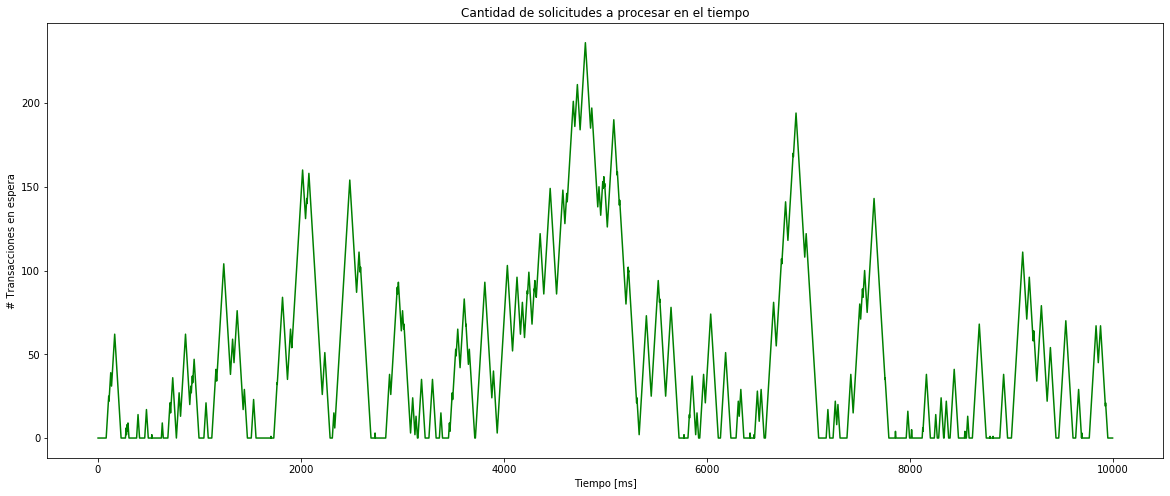

In [23]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_ylabel("# Transacciones en espera"); 
ax.set_xlabel("Tiempo [ms]")
ax.set_title("Cantidad de solicitudes a procesar en el tiempo")
ax.plot(range(10000), solicitudes_en_tiempo, 'g');

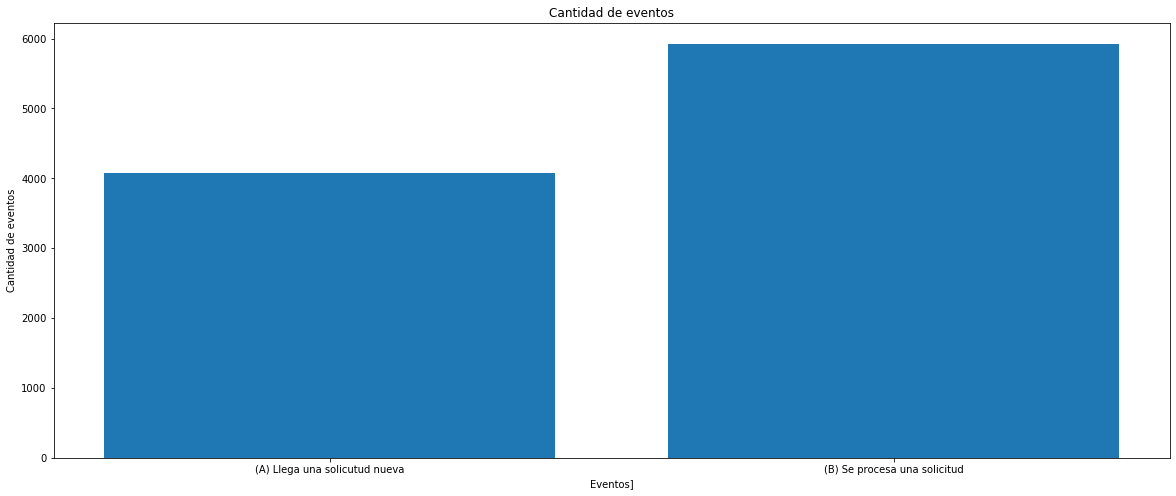

In [27]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_ylabel("Cantidad de eventos"); 
ax.set_xlabel("Eventos]")
ax.set_title("Cantidad de eventos")
ax.bar(x=['(A) Llega una solicutud nueva','(B) Se procesa una solicitud'],height=[cant_sin_procesar,10000-cant_sin_procesar]);

In [20]:
print('El servidor se encuentra un {}% del tiempo sin procesar solicitudes.'.format(cant_sin_procesar/(1000*10)*100))

El servidor se encuentra un 43.04% del tiempo sin procesar solicitudes.


## Ejercicio 3

In [1]:
import numpy as np
from matplotlib import pyplot as plt

Reescribiendo un poco el sistema propuesto:
![equation](http://bit.ly/2CiBV13)

Busco la matriz A de forma tal que:
![equation](http://bit.ly/33oPGXS)

![equation](http://bit.ly/32kE8Ue)

In [2]:
def get_matrix(a,b,c,d):
    return np.matrix([[-d/b,0],[d,0]])

Para buscar el punto de equilibrio, planteo:
![equation](http://bit.ly/2qqWYLY)
![equation](http://www.sciweavers.org/tex2img.php?eq=a%20-%20bP%20%3D%20dP%20-%20c&bc=White&fc=Black&im=jpg&fs=12&ff=arev&edit=0)
![equation](http://bit.ly/36CuGyP)

In [4]:
def punto_de_equilibrio(a,b,c,d):
    return (a+c)/(b+d)

Para realizar el análisis asintótico, busco los autovalores de la matriz Jacobiana.
![equation](http://bit.ly/32jteOz)
![equation](http://bit.ly/2NkBSrW)
![equation](http://bit.ly/2WK3fys)

In [5]:
def autovalores(a,b,c,d):
    return 0, -d/b

In [6]:
def next_price(a,b,c,d,p):
    return (a+c-d*p)/b

In [91]:
def plot_price(a,b,c,d,p_0,n=100):
    
    ps = [p_0]
    for i in range(n):
        ps.append(next_price(a,b,c,d,ps[-1]))
    
    fig,ax = plt.subplots(figsize=(20,10))
    ax.plot(ps)
    ax.set_title("4. P(t)",fontsize=20)
    plt.show()

In [70]:
def cobweb_plot(a, b, c, d, p_0, n, x0=0.1, iterations=50):
    
    ps = [p_0]
    for i in range(n):
        ps.append(next_price(a,b,c,d,ps[-1]))
    
    fig,ax = plt.subplots(figsize=(20,10))
    ax.plot(ps,label="Pt")
    
    ax.plot(range(len(ps)), color="red",label="Pt=t")
    ax.set_title("Cobweb Plot")
    
    last_x, last_y = x0, 0
    for _ in range(iterations):
        next_x = next_price(a,b,c,d,last_x)
        ax.plot([last_x, last_x], [last_y, next_x], color="black")
        plt.plot([last_x, next_x], [next_x, next_x], color="black")

        last_x, last_y = next_x, next_x
    
    ax.axvline(punto_de_equilibrio(a,b,c,d),color="green",label="punto de equilibrio")
    plt.legend(loc="upper left")
    plt.show()

A partir de las funciones previamente definidas, resuelvo las preguntas.

In [74]:
params = [
    (10,1,0.4,0.9,10),
    (0.9,0.89,0.5,0.9,1)
]

## a)

In [95]:
print("1.Matriz asociada")
print(get_matrix(*params[0][:4]))
print()
print("2.Punto de equilibrio")
print(punto_de_equilibrio(*params[0][:4]))

1.Matriz asociada
[[-0.9  0. ]
 [ 0.9  0. ]]

2.Punto de equilibrio
5.473684210526316


In [86]:
print("3.")
print("autovalores:",autovalores(*params[0][:4]))
print("Como |lambda1| < 1 y |lambda2| < 1, entonces es un punto estable")

3.
autovalores: (0, -0.9)
Como |lambda1| < 1 y |lambda2| < 1, entonces es un punto estable


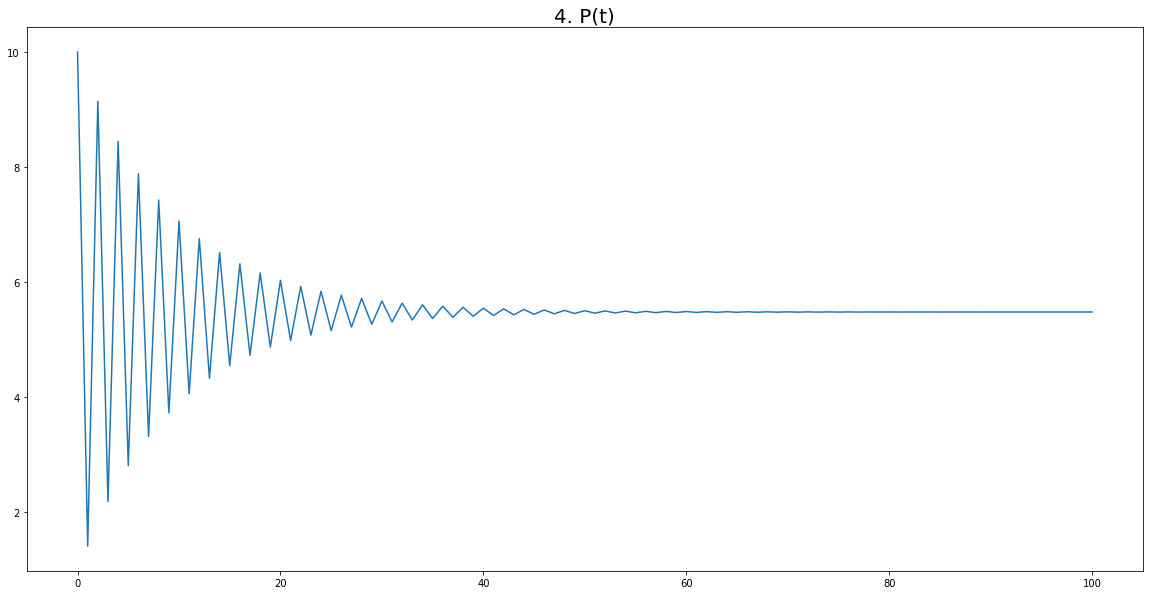

In [92]:
plot_price(*params[0])

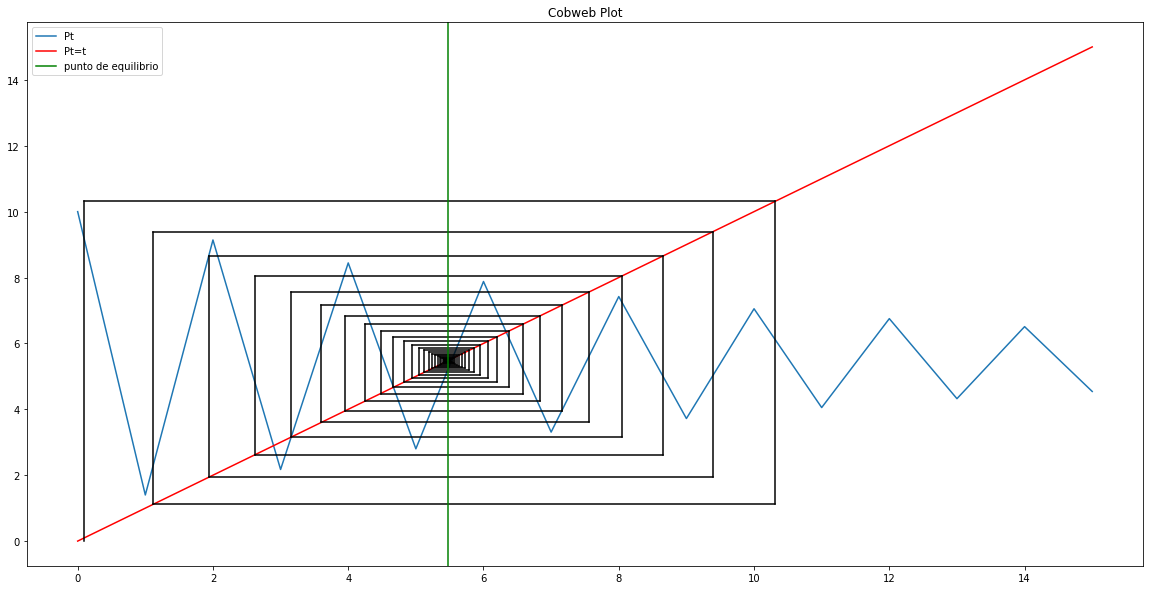

In [93]:
cobweb_plot(*params[0],15)

## b)

In [96]:
print("1.Matriz asociada")
print(get_matrix(*params[1][:4]))
print()
print("2.Punto de equilibrio")
print(punto_de_equilibrio(*params[1][:4]))

1.Matriz asociada
[[-1.01123596  0.        ]
 [ 0.9         0.        ]]

2.Punto de equilibrio
0.7821229050279329


In [98]:
print("3.")
print("autovalores:",autovalores(*params[1][:4]))
print("Como |lambda1| < 1 y |lambda2| > 1, entonces es un punto saddle")

3.
autovalores: (0, -1.0112359550561798)
Como |lambda1| < 1 y |lambda2| > 1, entonces es un punto saddle


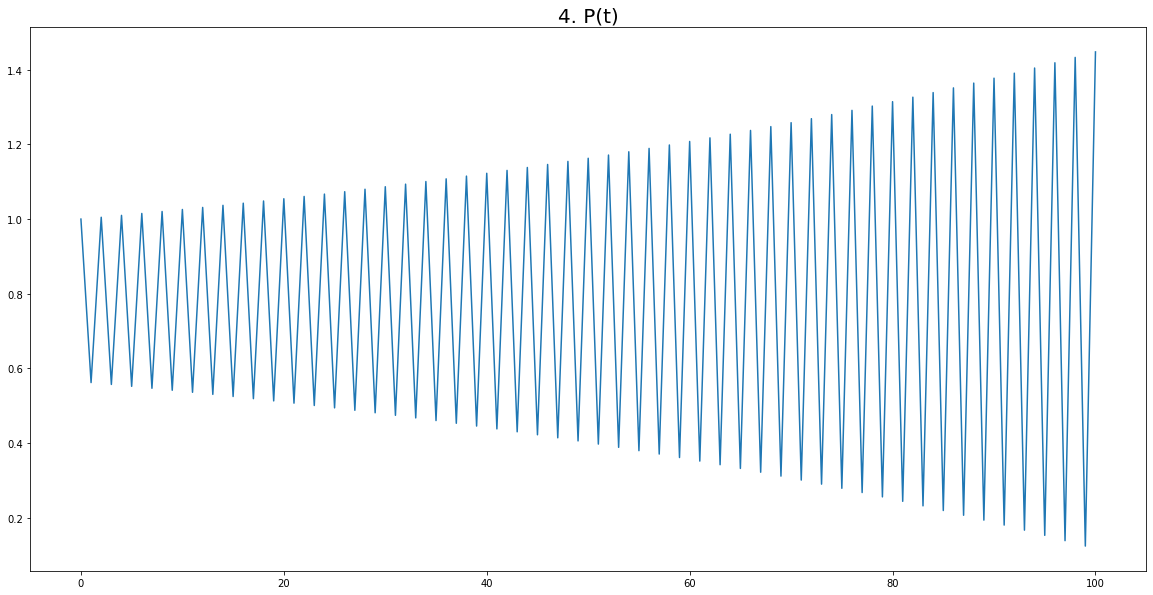

In [99]:
plot_price(*params[1])

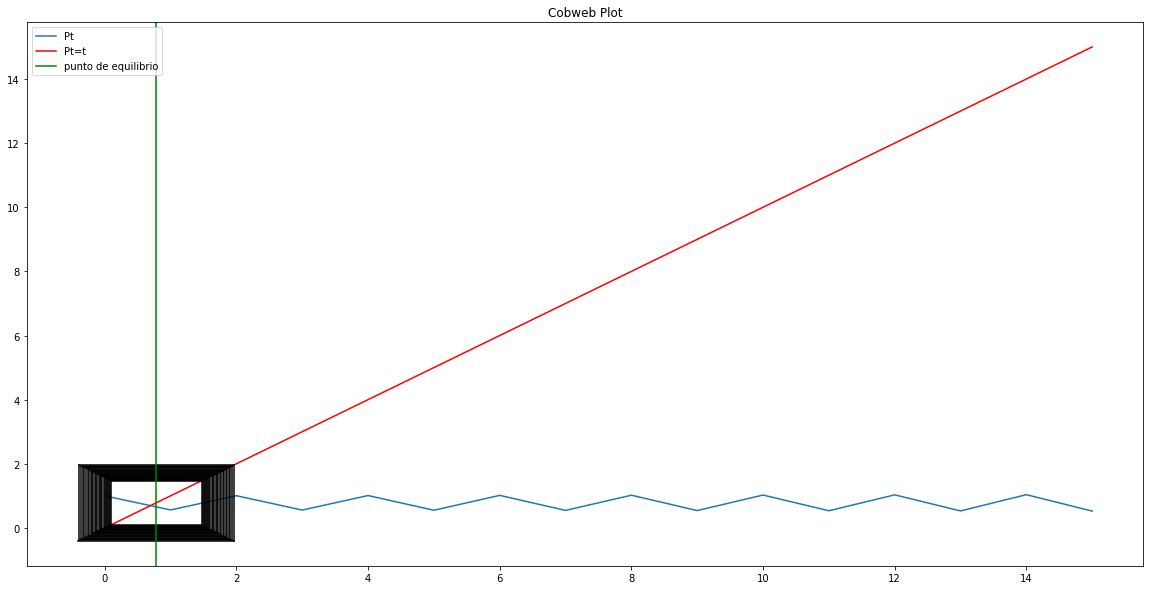

In [109]:
cobweb_plot(*params[1],15)

## Ejercicio 4

In [1]:
import numpy
import simpy
import random

In [44]:
SERVER1REQUESTMEDIAN=0.7
SERVER2REQUESTMEDIAN=1.0
PSERVER1=0.6
PSERVER2=1-PSERVER1

SERVER3REQUESTMEDIAN=0.8 #MODELO2

REQUESTINTERVALMEDIAN=4.0
REQUESTCOUNT=100000

#### MODELO1

In [45]:
def source2(env, number, interval, server1, server2, data):
    """Source generates requests randomly"""
    for i in range(number):
        if random.random()<=PSERVER1:
            c = request(env, 'Request%02d' % i, server1, SERVER1REQUESTMEDIAN, data)
            env.process(c)
            t = random.expovariate(1.0 / interval)
            yield env.timeout(t)
        else:
            c = request(env, 'Request%02d' % i, server2, SERVER2REQUESTMEDIAN, data)
            env.process(c)
            t = random.expovariate(1.0 / interval)
            yield env.timeout(t)
            
def request(env, name, server, requesttime, data):
    """Request arrives, and is resolved"""
    arrive = env.now

    with server.request() as req:
        
        results = yield req

        wait = env.now - arrive
        if wait>0:
            data[0]+=wait
            data[1]+=1
        
        tib = random.expovariate(1.0 / requesttime)
        yield env.timeout(tib)
        total_wait = env.now - arrive
        data[2]+=total_wait
        

In [46]:
env2=simpy.Environment()
server1=simpy.Resource(env2, 1)
server2=simpy.Resource(env2, 1)

data=[0,0,0]

env2.process(source2(env2, REQUESTCOUNT, REQUESTINTERVALMEDIAN, server1, server2, data))
env2.run()

#### MODELO2

In [47]:
def source(env, number, interval, server, data):
    """Source generates requests randomly"""
    for i in range(number):
        c = request(env, 'Request%02d' % i, server, SERVER3REQUESTMEDIAN, data)
        env.process(c)
        t = random.expovariate(1.0 / interval)
        yield env.timeout(t)


In [48]:
acum_tiempo=0

env=simpy.Environment()
server1=simpy.Resource(env, 1)
server2=simpy.Resource(env, 1)


data2=[0,0,0]

env.process(source(env, REQUESTCOUNT, REQUESTINTERVALMEDIAN, server1, data2))
env.run()

#### RESULTADOS MODELO1

In [49]:
print('El tiempo medio de cola de las requests es %7.4f' % (data[0]/float(REQUESTCOUNT)))
print('El porcentaje total de requests que no tuvieron que esperar es %7.4f: ' % (data[1]/float(REQUESTCOUNT)))
print('El tiempo medio de cola mas procesamiento es %7.4f' % (data[2]/float(REQUESTCOUNT)))

El tiempo medio de cola de las requests es  0.0933
El porcentaje total de requests que no tuvieron que esperar es  0.1032: 
El tiempo medio de cola mas procesamiento es  0.9118


#### RESULTADOS MODELO2

In [50]:
print('El tiempo medio de cola de las requests es %7.4f' % (data2[0]/float(REQUESTCOUNT)))
print('El porcentaje total de requests que no tuvieron que esperar es %7.4f: ' % (data2[1]/float(REQUESTCOUNT)))
print('El tiempo medio de cola mas procesamiento es %7.4f' % (data2[2]/float(REQUESTCOUNT)))

El tiempo medio de cola de las requests es  0.2044
El porcentaje total de requests que no tuvieron que esperar es  0.2009: 
El tiempo medio de cola mas procesamiento es  1.0062


#### CONCLUSION

In [51]:
if data[2]<data2[2]*0.5:
    print('Es conveniente elegir el modelo 1 ya que el tiempo medio para resolver cada solicitud es 50% menor que usando el modelo 2')
else: print('Es conveniente elegir el modelo 2 ya que el tiempo medio para resolver cada solicitud no es 50% menor usando el modelo 1')

Es conveniente elegir el modelo 2 ya que el tiempo medio para resolver cada solicitud no es 50% menor usando el modelo 1
